In [1]:
import datetime
import json
import os
import time
from collections import defaultdict

import datasets
import equinox as eqx
import jax
import librosa
import matplotlib.pyplot as plt
import numpy as np
import optax
from datasets import Array2D, Features, Value
from librosa.util import normalize

from hifigan import (
    Generator,
    mel_spec_base_jit,
)

SAMPLE_RATE = 22050
SEGMENT_SIZE = 8192
RANDOM = jax.random.key(0)
CHECKPOINT_PATH = "checkpoints"

def transform(sample):
    """Based off the original code that can be found here: https://github.com/jik876/hifi-gan/blob/master/meldataset.py

    Args:
        sample (dict): dict entry in HF Dataset

    Returns:
        dict: updated entry
    """
    k = jax.random.key(0)
    wav = sample["audio"]["array"]
    if sample["audio"]["sampling_rate"] != SAMPLE_RATE:
        librosa.resample(wav, sample["audio"]["sampling_rate"], SAMPLE_RATE)
    wav = normalize(wav) * 0.95
    if wav.shape[0] >= SEGMENT_SIZE:
        max_audio_start = wav.shape[0] - SEGMENT_SIZE
        audio_start = jax.random.randint(k, (1,), 0, max_audio_start)[0]
        wav = wav[audio_start : audio_start + SEGMENT_SIZE]

    wav = np.expand_dims(wav, 0)

    mel = mel_spec_base_jit(wav=wav)
    return {"mel": np.array(mel), "audio": np.array(wav), "sample_rate": SAMPLE_RATE}


# # Define the exact shapes we expect from the transform function
features = Features(
    {
        "mel": Array2D(
            shape=(80, 32), dtype="float32"
        ),  # From mel_spec_base_jit output
        "audio": Array2D(shape=(1, 8192), dtype="float32"),  # From expand_dims(wav, 0)
        "sample_rate": Value(dtype="int64"),
    }
)

# lj_speech_data.save_to_disk("transformed_lj_speech")
lj_speech_data = datasets.load_from_disk("transformed_lj_speech")
lj_speech_data = lj_speech_data.with_format("jax")

lj_speech_data = lj_speech_data["train"].train_test_split(0.01)

train_data, eval_data = lj_speech_data["train"], lj_speech_data["test"]

k1, k2, k3 = jax.random.split(RANDOM, 3)
generator = Generator(channels_in=80, channels_out=1, key=k1)


/home/tugdual/hifigan-jax/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:

generator = eqx.tree_deserialise_leaves("generator.eqx", generator)


In [22]:
test = train_data.take(1)
test

Dataset({
    features: ['mel', 'audio', 'sample_rate'],
    num_rows: 1
})

In [23]:
generator


Generator(
  conv_pre=Conv1d(
    num_spatial_dims=1,
    weight=f32[512,80,7],
    bias=f32[512,1],
    in_channels=80,
    out_channels=512,
    kernel_size=(7,),
    stride=(1,),
    padding=((3, 3),),
    dilation=(1,),
    groups=1,
    use_bias=True,
    padding_mode='ZEROS'
  ),
  layers=[
    (
      ConvTranspose1d(
        num_spatial_dims=1,
        weight=f32[256,512,16],
        bias=f32[256,1],
        in_channels=512,
        out_channels=256,
        kernel_size=(16,),
        stride=(8,),
        padding='SAME',
        output_padding=(0,),
        dilation=(1,),
        groups=1,
        use_bias=True,
        padding_mode='ZEROS'
      ),
      MRF(
        resblocks=[
          ResBlock(
            conv_dil=[
              Conv1d(
                num_spatial_dims=1,
                weight=f32[256,256,3],
                bias=f32[256,1],
                in_channels=256,
                out_channels=256,
                kernel_size=(3,),
                stride=(1,),


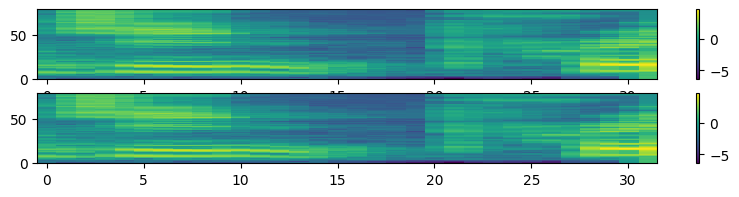

In [29]:
from IPython.display import Audio, display
from matplotlib import pyplot as plt

mel = test["mel"]
wav = test["audio"]
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 2))
im = ax1.imshow(mel[0], aspect="auto", origin="lower", interpolation="none")
plt.colorbar(im, ax=ax1)


wav_pred = generator(mel[0])
mel_pred = mel_spec_base_jit(wav_pred)
im2 = ax2.imshow(mel[0], aspect="auto", origin="lower", interpolation="none")
plt.colorbar(im, ax=ax2)
fig.canvas.draw()

In [30]:
display(Audio(wav[0], rate=16000))
display(Audio(wav_pred[0], rate=16000))
